In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import ast

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split


# DATA

In [2]:
data = pd.read_csv('main_task.csv')
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [3]:
# Фукнция для расчета медианы одной переменной с учетом группировки по другой переменной
def calc_mean(df,categ,calc):
    return df.groupby(categ)[calc].median()

# Фукнция для перевода строки в список
def str_to_list(i):
    return ast.literal_eval(i)

## Обработка признаков
Пройдемся по каждому признаку и приведем предварительную обработку. Посмотрим на пропуски и создадим новые признаки.

In [4]:
data.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style         9283
Ranking                  0
Rating                   0
Price Range          13886
Number of Reviews     2543
Reviews                  0
URL_TA                   0
ID_TA                    0
dtype: int64

Cuisine Style, Price Range и Number of Reviews содержат пропуски

In [5]:
data.Restaurant_id.value_counts()

id_227      18
id_633      18
id_436      18
id_871      18
id_534      17
            ..
id_13476     1
id_14931     1
id_3799      1
id_14525     1
id_16253     1
Name: Restaurant_id, Length: 11909, dtype: int64

Сетевые рестораны (где кол-во больше 1) - сетевые рестораны, поставим по ним признак 1

In [6]:
chain_lst = list(data.Restaurant_id.value_counts()[data.Restaurant_id.value_counts() > 1].index)
data['chain'] = data[data.Restaurant_id.isin(chain_lst)].Restaurant_id.apply(lambda x: 1)
data['chain'].fillna(0, inplace=True)

In [7]:
data['chain'].value_counts()

1.0    35295
0.0     4705
Name: chain, dtype: int64

## City

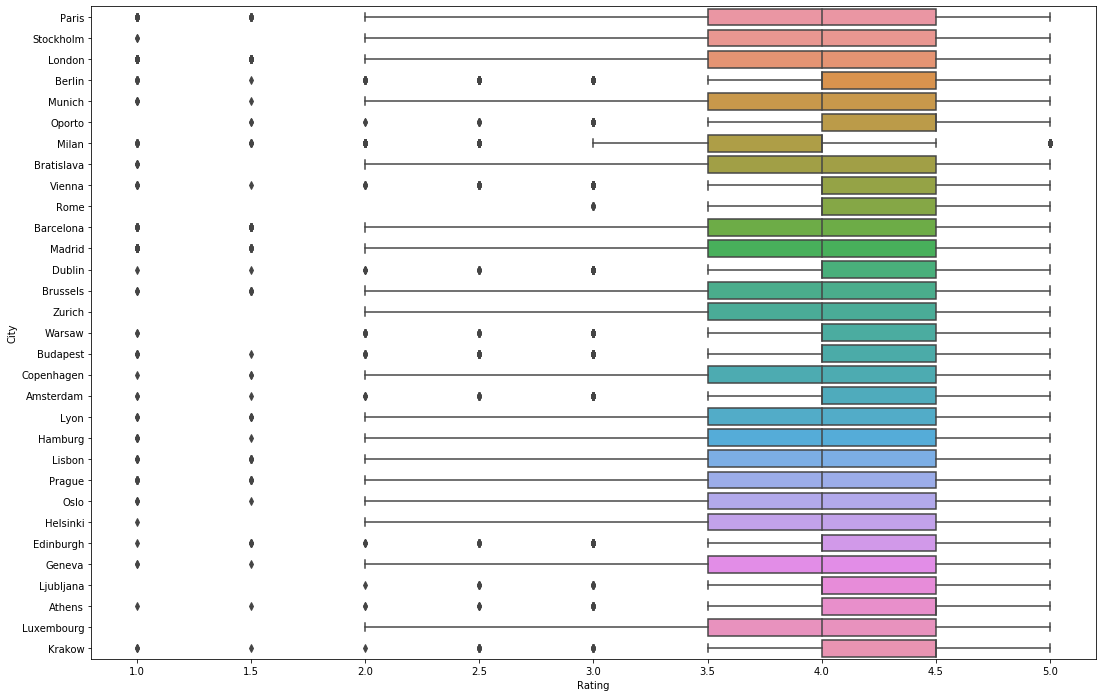

In [8]:
plt.figure(figsize=(18, 12))
sns.boxplot(x='Rating', y='City', data=data);

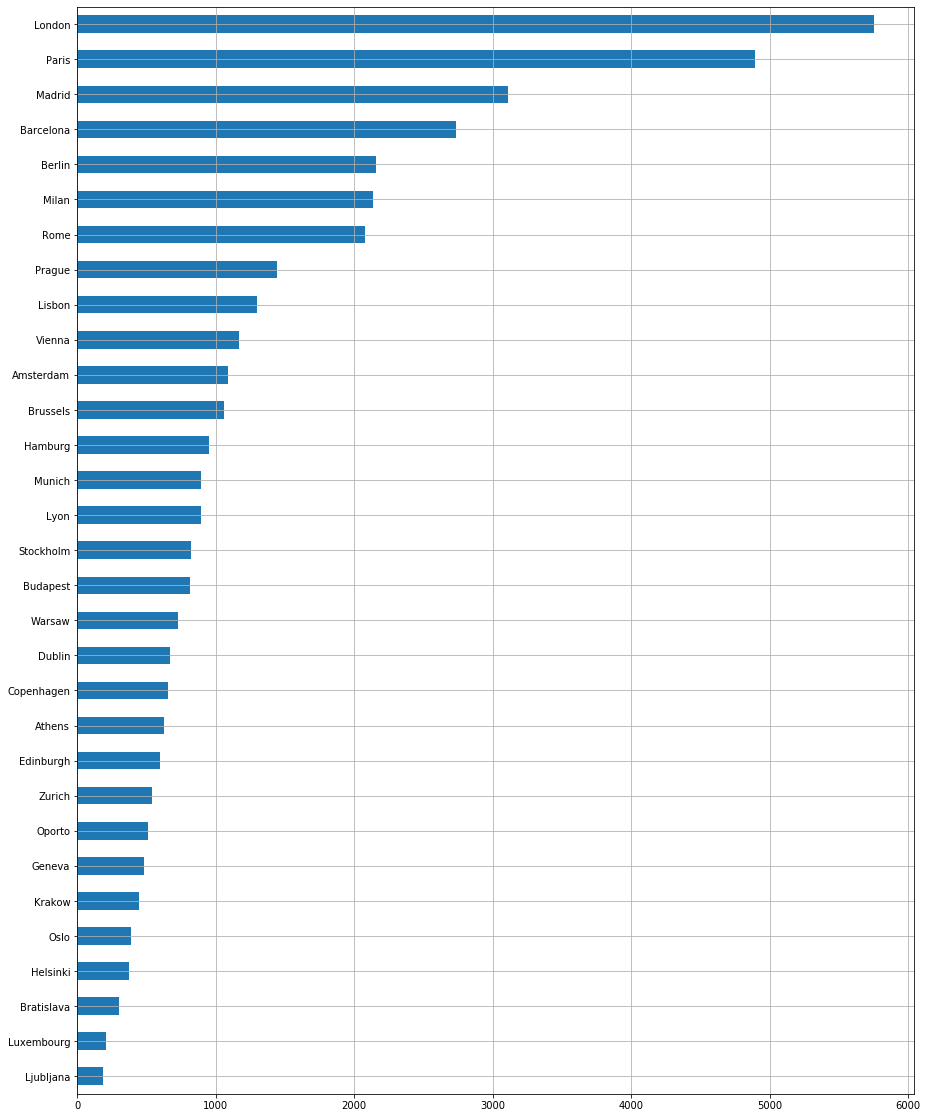

In [9]:
plt.figure(figsize=(15, 20))
data.City.value_counts(ascending=True).plot(
    kind='barh', grid=True);

In [10]:
city_lst = data.City.unique()


## Price Range
Заменим пропуски и изменим значения от 1 до 3.

In [11]:
data['Price Range'].value_counts(dropna=False)

$$ - $$$    18412
NaN         13886
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [12]:
data['Price Range'].replace(['$','$$ - $$$','$$$$'],[1,2,3],inplace=True)

In [13]:
PR_Med_City = calc_mean(data,'City','Price Range')

In [14]:
PR_Med_City

City
Amsterdam     2.0
Athens        2.0
Barcelona     2.0
Berlin        2.0
Bratislava    2.0
Brussels      2.0
Budapest      2.0
Copenhagen    2.0
Dublin        2.0
Edinburgh     2.0
Geneva        2.0
Hamburg       2.0
Helsinki      2.0
Krakow        2.0
Lisbon        2.0
Ljubljana     2.0
London        2.0
Luxembourg    2.0
Lyon          2.0
Madrid        2.0
Milan         2.0
Munich        2.0
Oporto        2.0
Oslo          2.0
Paris         2.0
Prague        2.0
Rome          2.0
Stockholm     2.0
Vienna        2.0
Warsaw        2.0
Zurich        2.0
Name: Price Range, dtype: float64

In [15]:
# медиана у всех городов = 2
# заменим пропуски на 2
data['Price Range'].fillna(2,inplace=True)

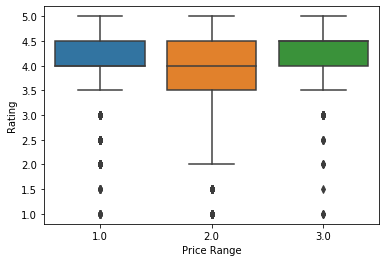

In [16]:
sns.boxplot(x='Price Range', y='Rating', data=data);

## Cuisine Style

In [17]:
# заполним пропуски значением other
data['Cuisine Style'].fillna("['Other']", inplace = True)

In [18]:
# преобразуем строки Cuisine Style в списки
data['Cuisine Style']=data[data['Cuisine Style'].isna()==False]['Cuisine Style'].map(str_to_list)


In [19]:
data['Cuisine Style'].isna().sum()

0

In [20]:
# Создадим признак 'cuisine_count' - количество представленных кухонь в ресторане.
data['cuisine_count'] = data['Cuisine Style'].apply(lambda x: len(x))

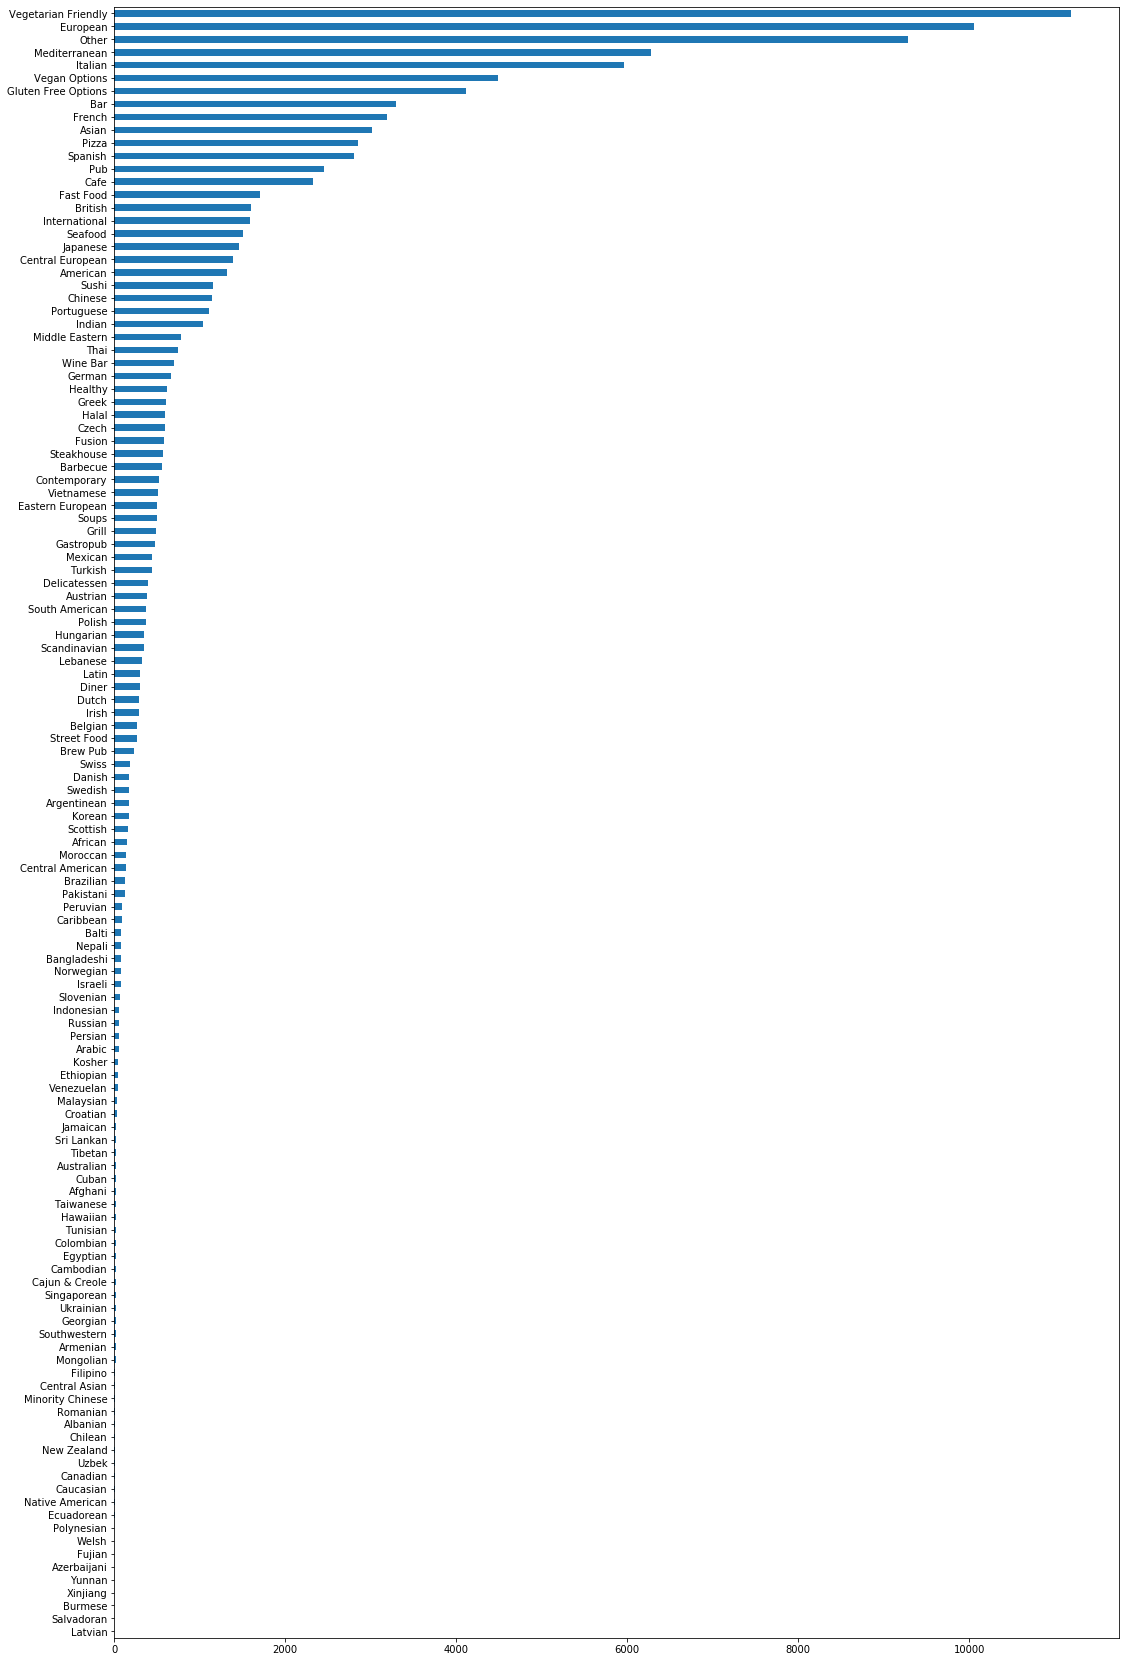

In [21]:
# Список уникальных кухонь
cuisine_lst = data.explode('Cuisine Style')['Cuisine Style'].value_counts(ascending=True)
plt.figure(figsize=(18,30))
cuisine_lst.plot(kind='barh');

In [22]:
# объеденим кухни в боллее крупные кластеры
cuisine_lst_group = pd.Series(cuisine_lst.index, index = cuisine_lst.index)

In [23]:
pd.options.display.max_rows=126
cuisine_lst_group

Latvian                            Latvian
Salvadoran                      Salvadoran
Burmese                            Burmese
Xinjiang                          Xinjiang
Yunnan                              Yunnan
Azerbaijani                    Azerbaijani
Fujian                              Fujian
Welsh                                Welsh
Polynesian                      Polynesian
Ecuadorean                      Ecuadorean
Native American            Native American
Caucasian                        Caucasian
Canadian                          Canadian
Uzbek                                Uzbek
New Zealand                    New Zealand
Chilean                            Chilean
Albanian                          Albanian
Romanian                          Romanian
Minority Chinese          Minority Chinese
Central Asian                Central Asian
Filipino                          Filipino
Mongolian                        Mongolian
Armenian                          Armenian
Southwester

In [24]:
cuisine_lst_group[['Italian','French','Spanish','Latvian','Welsh','Albanian','Romanian','Croatian','Slovenian','Norwegian','Balti','Swedish','Danish','Swiss','Belgian','Irish','Dutch','Scandinavian','Hungarian','Polish','Austrian','Eastern European','Czech','Greek','German','Portuguese','Central European','British','Spanish','Mediterranean','Scottish']] = 'European'
cuisine_lst_group[['Brew Pub','Wine Bar','Pub','Bar']]='Alcohol'
cuisine_lst_group[['Yunnan','Xinjiang','Fujian','Minority Chinese','Central Asian','Taiwanese','Tibetan','Korean','Vietnamese','Thai','Chinese','Asian','Singaporean']]='Asian'
cuisine_lst_group['Sushi']='Japanese'
cuisine_lst_group['Gastropub']='Delicatessen'
cuisine_lst_group['Street Food']='Fast Food'
cuisine_lst_group[['Grill','Barbecue','Steakhouse']]='Meat'
cuisine_lst_group[['Ecuadorean','Chilean','Colombian','Venezuelan','Peruvian','Brazilian','Argentinean','Latin']]='South American'
cuisine_lst_group[['Vegetarian Friendly','Vegan Options','Gluten Free Options','Healthy']]='Healthy'

In [25]:
len(cuisine_lst_group.value_counts(ascending=True))

65

In [26]:
# функция для формирования списка кухонь с учетом группировки
def new_cuisine(lst):
    new_lst=[]
    for k in lst:
        if cuisine_lst_group[k] not in new_lst:
            new_lst.append(cuisine_lst_group[k])
    return new_lst

In [27]:
data['new_cus'] = data['Cuisine Style'].apply(new_cuisine)

In [28]:
data

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,chain,cuisine_count,new_cus
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,2.0,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1.0,3,"[European, International]"
1,id_1535,Stockholm,[Other],1537.0,4.0,2.0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1.0,1,[Other]
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,3.0,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1.0,7,"[Japanese, Asian, Meat, Healthy]"
3,id_3456,Berlin,[Other],3458.0,5.0,2.0,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1.0,1,[Other]
4,id_615,Munich,"[German, Central European, Vegetarian Friendly]",621.0,4.0,2.0,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,1.0,3,"[European, Healthy]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,4.5,2.0,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1.0,4,"[European, Healthy]"
39996,id_6340,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,3.5,2.0,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1.0,5,"[European, American, Alcohol, Healthy]"
39997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,4.5,2.0,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1.0,2,[Japanese]
39998,id_640,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,4.0,2.0,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1.0,5,"[European, Healthy]"


In [29]:
# Кухни, встречающиеся меньше 50 раз, будем считать редкими.
cuisine_rare_lst = data.explode('Cuisine Style')['Cuisine Style'].value_counts()[
    data.explode('Cuisine Style')['Cuisine Style'].value_counts() < 50].index.tolist()

In [30]:
def cuisine_rare_count(cell):
    '''Количество редких кухонь в ресторане'''
    x = 0
    for i in cuisine_rare_lst:
        if i in cell:
            x += 1
    return x

In [31]:
data['cuisine_rare'] = data['Cuisine Style'].apply(cuisine_rare_count)

In [32]:
# Сформируем список уникальных значений кухонь Cuisine_Style
Cuisine_list = list(data.explode('Cuisine Style')['Cuisine Style'].unique())

In [33]:
len(Cuisine_list)

126

In [34]:
data

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,chain,cuisine_count,new_cus,cuisine_rare
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,2.0,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1.0,3,"[European, International]",0
1,id_1535,Stockholm,[Other],1537.0,4.0,2.0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1.0,1,[Other],0
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,3.0,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1.0,7,"[Japanese, Asian, Meat, Healthy]",0
3,id_3456,Berlin,[Other],3458.0,5.0,2.0,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1.0,1,[Other],0
4,id_615,Munich,"[German, Central European, Vegetarian Friendly]",621.0,4.0,2.0,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,1.0,3,"[European, Healthy]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,4.5,2.0,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1.0,4,"[European, Healthy]",0
39996,id_6340,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,3.5,2.0,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1.0,5,"[European, American, Alcohol, Healthy]",0
39997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,4.5,2.0,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1.0,2,[Japanese],0
39998,id_640,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,4.0,2.0,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1.0,5,"[European, Healthy]",0


In [35]:
# создадим dummy переменные для сгруппированых кухонь
tmp = list(data.explode('new_cus')['new_cus'].value_counts(ascending=False).index)

for i in tmp:
    data[i] = data['new_cus'].apply(lambda x: 1 if i in x else 0)
data.loc[:,'Other']=data[tmp].sum(axis=1).apply(lambda x: 1 if x == 0 else 0)


## Reviews

In [36]:
data['Reviews'] = data.Reviews.dropna().apply(
    lambda x: eval(x.replace('nan', '').replace('[,', "['',")))
data['Reviews'] = data['Reviews'].dropna().apply(
    lambda x: np.nan if len(x[0]) == 0 & len(x[1]) == 0 else x)

In [37]:
data['date'] = data['Reviews'].dropna().apply(lambda x: x[1])
data['date_1'] = data['date'].dropna().apply(lambda x: x[1] if len(x) == 2 else np.nan)
data['date_2'] = data['date'].dropna().apply(lambda x: x[0] if len(x) > 0 else np.nan)
data.drop('date', axis=1, inplace=True)

In [38]:
data['date_1'] = pd.to_datetime(data['date_1'])
data['date_2'] = pd.to_datetime(data['date_2'])

In [39]:
data['date_1'].fillna(data['date_1'].min(), inplace=True)
data['date_2'].fillna(data['date_2'].max(), inplace=True)

In [40]:
# Создадим признак разницы дней между последними двумя отзывами.
data['review_days'] = abs(data['date_2'] - data['date_1']).dt.days

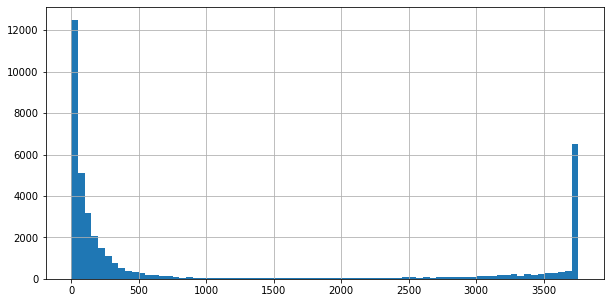

In [41]:
plt.figure(figsize=(10,5))
data['review_days'].hist(bins=75);

In [42]:
data['days_to_today'] = (datetime.now() - data['date_2']).dt.days
data['days_to_today']

0        1106
1        1284
2        1098
3        1049
4        1149
         ... 
39995    1121
39996    1116
39997    1529
39998    1279
39999    1806
Name: days_to_today, Length: 40000, dtype: int64

In [43]:
# Обработаем отзывы. Создадим признак количества последних коментариев (0-2)
data['Reviews'] = data['Reviews'].dropna().apply(lambda x: x[0])



In [44]:
data['last_rewiew_counts'] = data['Reviews'].dropna().apply(
    lambda x: 2 if len(x) == 2 else 1 if len(x) == 1 else 0)

In [45]:
data.last_rewiew_counts.fillna(0, inplace=True)

In [46]:
def len_rewiews(cell):
    x = 0
    for i in cell:
        x += len(i)
    return x

In [47]:
data['len_rewiews'] = data['Reviews'].dropna().apply(len_rewiews)
data['len_rewiews'].fillna(0, inplace=True)

In [48]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Polynesian,Azerbaijani,Burmese,Salvadoran,date_1,date_2,review_days,days_to_today,last_rewiew_counts,len_rewiews
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,2.0,194.0,"[Good food at your doorstep, A good hotel rest...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,...,0,0,0,0,2017-11-20,2017-12-31,41,1106,2.0,49.0
1,id_1535,Stockholm,[Other],1537.0,4.0,2.0,10.0,"[Unique cuisine, Delicious Nepalese food]",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,...,0,0,0,0,2016-06-19,2017-07-06,382,1284,2.0,37.0
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,3.0,688.0,"[Catch up with friends, Not exceptional]",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,...,0,0,0,0,2018-01-06,2018-01-08,2,1098,2.0,36.0
3,id_3456,Berlin,[Other],3458.0,5.0,2.0,3.0,NaN,/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,...,0,0,0,0,2007-11-14,2018-02-26,3757,1049,0.0,0.0
4,id_615,Munich,"[German, Central European, Vegetarian Friendly]",621.0,4.0,2.0,84.0,"[Best place to try a Bavarian food, Nice build...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,...,0,0,0,0,2017-02-19,2017-11-18,272,1149,2.0,77.0


## Number of Reviews

In [52]:
# Заполним пропуски в колонке Number of Reviews
data.loc[(data['last_rewiew_counts'] == 0) & (
    data['Number of Reviews'].isna()), 'Number of Reviews'] = 0
data.loc[(data['last_rewiew_counts'] == 1) & (
    data['Number of Reviews'].isna()), 'Number of Reviews'] = 1

Создадим признак отношения рейтинга в городе к количеству отзывов в городе.

In [53]:
rewiews_city_dict = dict(data.groupby('City')['Number of Reviews'].sum())
data['num_rewiews_city'] = data.City.map(rewiews_city_dict)
data['relative_rank_reviews'] = data['Ranking'] / data['num_rewiews_city']

## Ranking

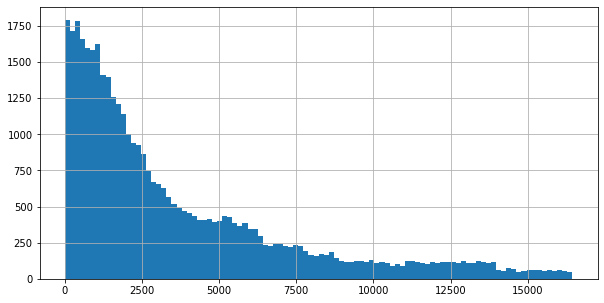

In [54]:
plt.rcParams['figure.figsize'] = (10,5)
data['Ranking'].hist(bins=100);

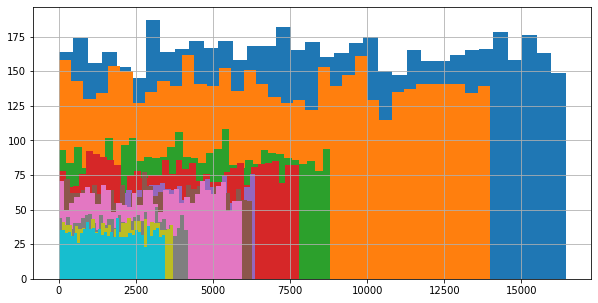

In [55]:
# посмотрим на топ 10 городов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=35)

Разделим Ranking на количество ресторанов в городе.

In [56]:
# Создадим признак количество ресторанов в городе.
city_counts_dict = dict(data['City'].value_counts())
data['rest_counts'] = data.City.map(city_counts_dict)

data['ranking_norm'] = data.Ranking / data.rest_counts

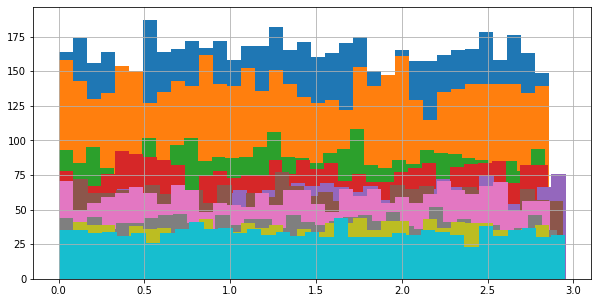

In [57]:
for x in (data['City'].value_counts())[0:10].index:
    data['ranking_norm'][data['City'] == x].hist(bins=35)

In [58]:
# добавим dummies переменные по городам:
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

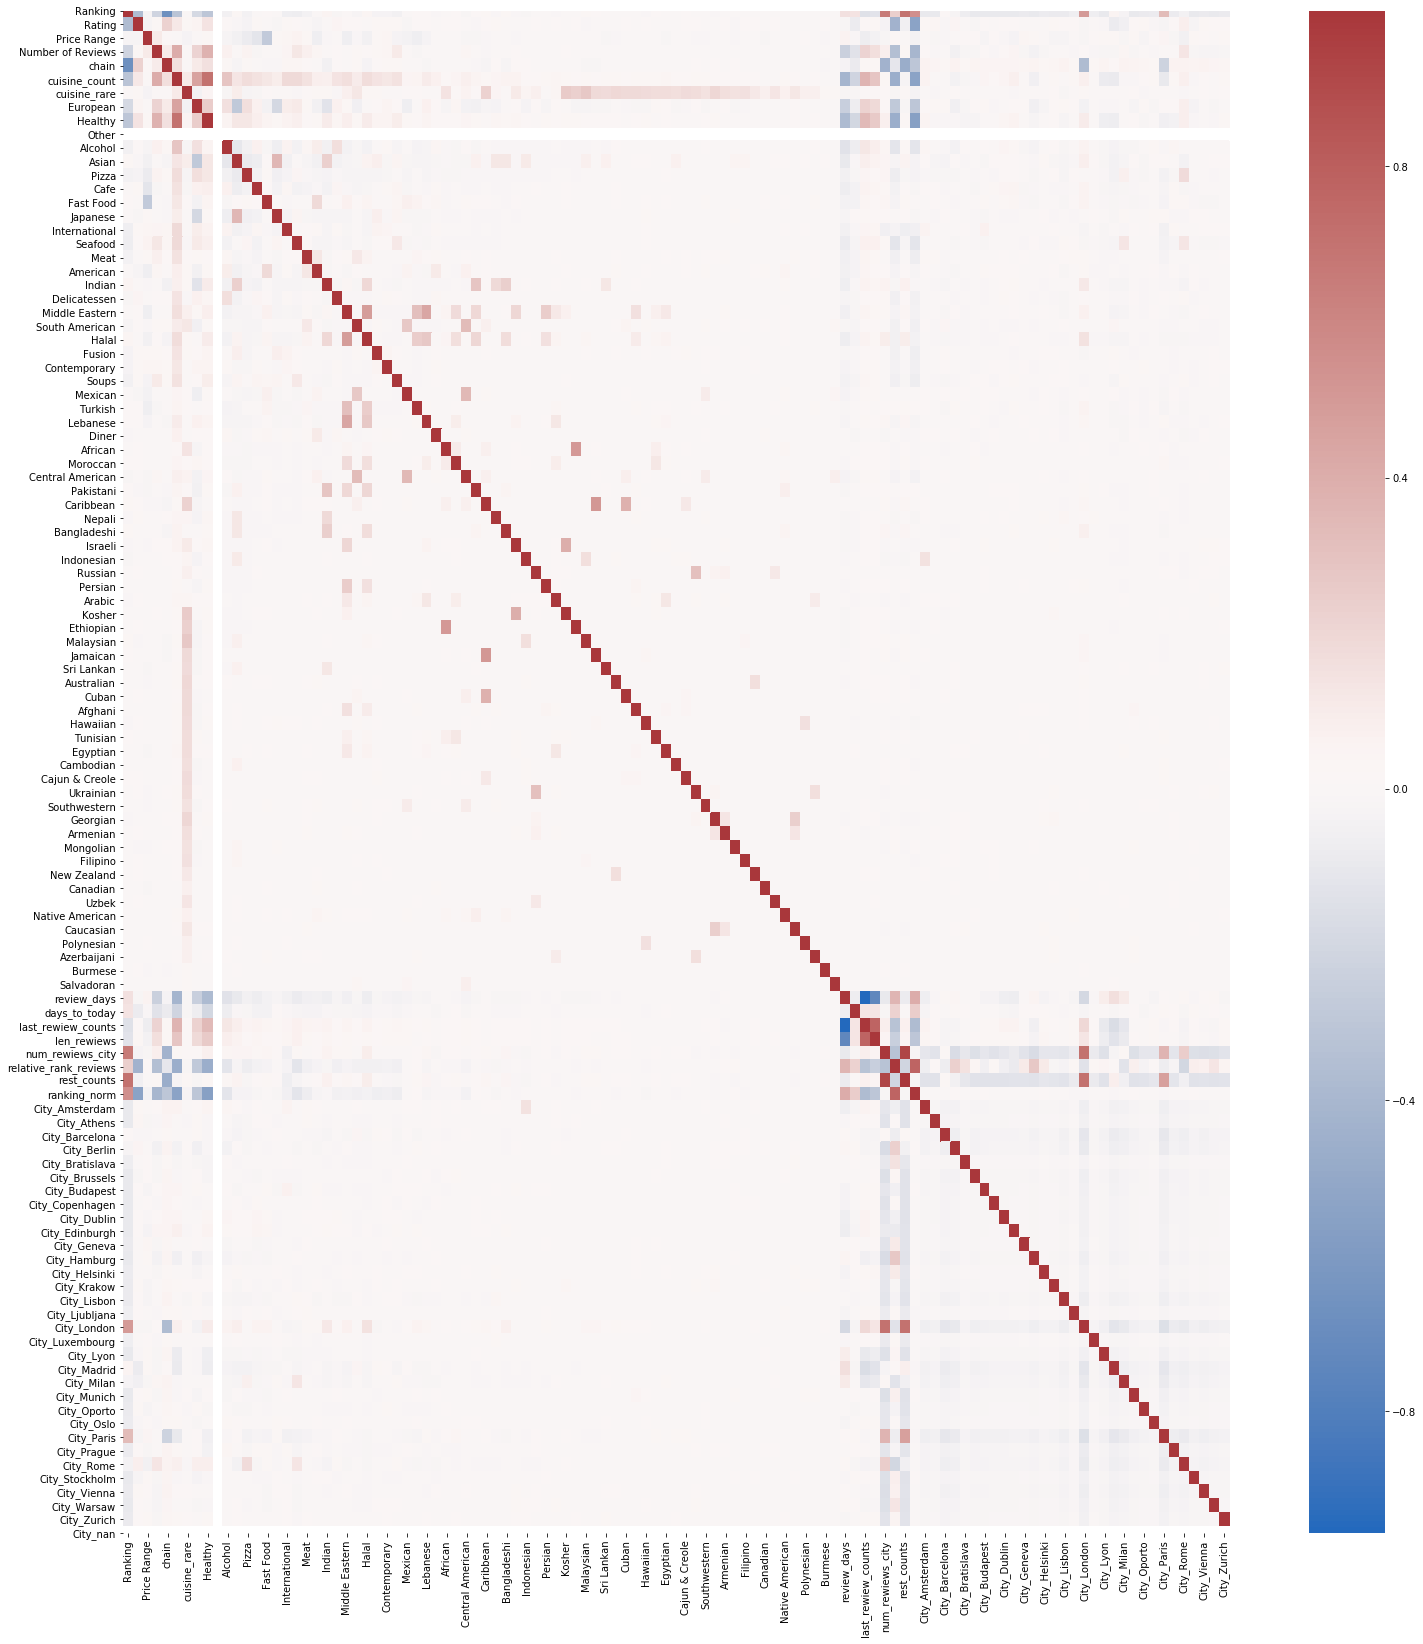

In [59]:
plt.rcParams['figure.figsize'] = (25,28)
sns.heatmap(data.corr(), cmap='vlag');

In [60]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Сделаем функцию для проверки MAE
def Check_MAE(df):
## Разбиваем датафрейм на части, необходимые для обучения и тестирования модели      
    # Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
    X = df.drop(['Restaurant_id', 'Rating'], axis=1)
    y = df['Rating']
    
    # Загружаем специальный инструмент для разбивки:
    #from sklearn.model_selection import train_test_split
    
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
    # Для тестирования мы будем использовать 25% от исходного датасета.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    # Создаём модель
    regr = RandomForestRegressor(n_estimators=100)

    # Обучаем модель на тестовом наборе данных
    regr.fit(X_train, y_train)

    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    y_pred = regr.predict(X_test)

    # Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
    # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
    # print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    return metrics.mean_absolute_error(y_test, y_pred)

In [62]:
data=data.drop(['Cuisine Style','Reviews','URL_TA','ID_TA','date_1','date_2','new_cus'],axis='columns')

In [63]:
data

,Restaurant_id,Ranking,Rating,Price Range,Number of Reviews,chain,cuisine_count,cuisine_rare,European,Healthy,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_5569,5570.0,3.5,2.0,194.0,1.0,3,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,id_1535,1537.0,4.0,2.0,10.0,1.0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,id_352,353.0,4.5,3.0,688.0,1.0,7,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,id_3456,3458.0,5.0,2.0,3.0,1.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_615,621.0,4.0,2.0,84.0,1.0,3,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_499,500.0,4.5,2.0,79.0,1.0,4,0,1,1,...,0,0,0,0,0,0,0,0,0,0
39996,id_6340,6341.0,3.5,2.0,542.0,1.0,5,0,1,1,...,0,0,1,0,0,0,0,0,0,0
39997,id_1649,1652.0,4.5,2.0,4.0,1.0,2,0,0,0,...,0,0,0,0,0,1,0,0,0,0
39998,id_640,641.0,4.0,2.0,70.0,1.0,5,0,1,1,...,0,0,0,0,0,0,0,1,0,0


In [64]:
Check_MAE(data)

0.2035805